In [1]:
import tilelit as ti

In [2]:
import skimage.io as sio

In [3]:
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import boto3
from scipy.misc import imsave

In [5]:
case = 'case01'
stain = "ER"

In [6]:
# for the first time you'll need to run through this to resize:
data_path = op.join(op.expanduser('~'), 'data', 'path')
stain_file = op.join(data_path, 'raw', case, case) + '-%s.tiff'%stain
he_file = op.join(data_path, 'raw', case, case) + '-H&E.tiff'
for fname in [stain_file, he_file]:
    resized_file = op.join(data_path, 'derived', op.split(fname)[-1].split('.')[0] + '_resize_10.npy')
    print(resized_file)
    if not op.exists(resized_file):
        resized = ti.tiff_resize(fname)
        np.save(resized_file, resized)

/home/ubuntu/data/path/derived/case01-ER_resize_10.npy
/home/ubuntu/data/path/derived/case01-H&E_resize_10.npy


In [7]:
im_stain = np.load(op.join(data_path, 'derived', case + '-' + stain + '_resize_10.npy'))
im_he = np.load(op.join(data_path, 'derived', case + '-H&E_resize_10.npy'))

In [8]:
im_stain.shape

(3008, 2340, 4)

In [9]:
im_he.shape

(2811, 2700, 4)

In [10]:
img_stain_bw = im_stain[..., 2] #np.sum(im_er, -1)
img_he_bw = im_he[..., 2] #np.sum(im_he, -1)

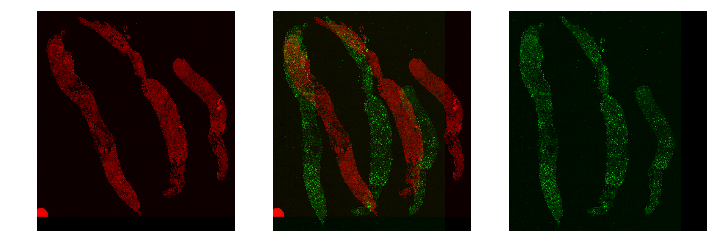

In [11]:
im1, im2 = ti.plot_together(1-img_he_bw, 1-(img_stain_bw/img_stain_bw.max()))

In [12]:
img_initial, aff_initial  = ti.initial_alignment(img_stain_bw, img_he_bw)

In [13]:
print(aff_initial)

[[   0.94991326   -0.29582371  229.24056777]
 [   0.30102363    0.95867318 -143.16843754]
 [   0.            0.            1.        ]]


In [14]:
#aff_initial=np.eye(3)

In [15]:
img_final, aff_final = ti.fine_alignment(img_stain_bw, img_he_bw, starting_affine=aff_initial)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


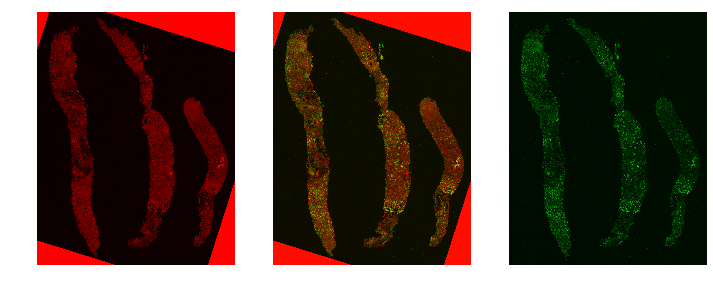

In [16]:
new_image1, new_image2 = ti.plot_together(1-(img_final/img_final.max()), 1-(img_stain_bw/img_stain_bw.max()))
#new_image1, new_image2 = plot_together(ax, img_final, img_er_bw)

In [17]:
aff_final

array([[   0.95013535,   -0.29663594,  229.44655329],
       [   0.30368251,    0.9544271 , -141.82584384],
       [   0.        ,    0.        ,    1.        ]])

In [18]:
im_stain_orig = sio.imread(stain_file)
im_he_orig = sio.imread(he_file)

/home/ubuntu/anaconda3/lib/python3.5/site-packages/skimage/external/tifffile/tifffile.py:2573: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  tile = decompress(tile)
/home/ubuntu/anaconda3/lib/python3.5/site-packages/skimage/external/tifffile/tifffile.py:2579: UserWarning: invalid tile data
  warnings.warn("invalid tile data")


In [19]:
im_stain_orig.shape, im_he_orig.shape

((30086, 23400, 4), (28114, 27000, 4))

In [20]:
box_size = (280, 280)

In [21]:
client = boto3.resource('s3', region_name='us-west-2')
bucket_name = 'arokem.path'
b = client.Bucket(bucket_name)

In [22]:
aff_orig = np.copy(aff_final)
aff_orig[:, 2] = aff_orig[:, 2] * 10

In [25]:
ii = 1
foo = 0
for y_corner in np.arange(0, im_stain_orig.shape[0], box_size[0]):
    for x_corner in np.arange(0, im_stain_orig.shape[1], box_size[1]):
        y_center = y_corner + box_size[0] // 2
        x_center = x_corner + box_size[1] // 2
        foo +=1 
        x_coords, y_coords = np.meshgrid(np.arange(x_center - box_size[1] // 2, x_center + box_size[1] // 2),
                                         np.arange(y_center - box_size[0] // 2, y_center + box_size[0] // 2))

        coords = np.array(list(zip(x_coords.ravel(), y_coords.ravel(), np.ones(np.product(box_size))))).astype(int)
        if not (np.any(coords[:, 0] > im_stain_orig.shape[0]) or 
                np.any(coords[:, 1] > im_stain_orig.shape[1])):
            im_stain_tile = im_stain_orig[(coords[:, 0], coords[:, 1])].reshape(box_size + (-1, ))
            trans_coords = (np.round(np.dot(aff_orig, coords.T))).T.astype(int)
            if not (np.any(trans_coords < 0) or 
                    np.any(trans_coords[:, 0] > im_he_orig.shape[0]) or 
                    np.any(trans_coords[:, 1] > im_he_orig.shape[1])):
                im_he_tile = im_he_orig[(trans_coords[:, 0], trans_coords[:, 1])].reshape(box_size + (-1, ))
                mean_tile = im_he_tile[:, :, :3].mean()
                if mean_tile < 240:
                    local_he_trans = './he-case%s-%s.png'%(case, stain)
                    imsave(local_he_trans, im_he_tile)
                    remote_he = op.join(case, 'tiles-%s'%stain, 'HE%08d.png' % ii)
                    b.upload_file(local_he_trans, remote_he)
                    local_stain ='./stain-case%s-%s.png'%(case, stain)
                    imsave(local_stain, im_stain_tile)
                    remote_stain = op.join(case, 'tiles-%s'%stain, '%s%08d.png'%(stain, ii))
                    if not np.mod(ii, 50):
                        print(remote_stain)
                    b.upload_file(local_stain, remote_stain)
                    ii = ii + 1


/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:23: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:27: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


case01/tiles-ER/ER00000050.png
case01/tiles-ER/ER00000100.png
case01/tiles-ER/ER00000150.png
case01/tiles-ER/ER00000200.png
case01/tiles-ER/ER00000250.png
case01/tiles-ER/ER00000300.png
case01/tiles-ER/ER00000350.png
case01/tiles-ER/ER00000400.png
case01/tiles-ER/ER00000450.png
case01/tiles-ER/ER00000500.png
case01/tiles-ER/ER00000550.png
case01/tiles-ER/ER00000600.png
case01/tiles-ER/ER00000650.png
case01/tiles-ER/ER00000700.png
case01/tiles-ER/ER00000750.png
case01/tiles-ER/ER00000800.png
case01/tiles-ER/ER00000850.png
case01/tiles-ER/ER00000900.png
case01/tiles-ER/ER00000950.png
case01/tiles-ER/ER00001000.png
case01/tiles-ER/ER00001050.png
case01/tiles-ER/ER00001100.png
case01/tiles-ER/ER00001150.png
case01/tiles-ER/ER00001200.png
case01/tiles-ER/ER00001250.png
case01/tiles-ER/ER00001300.png
case01/tiles-ER/ER00001350.png
case01/tiles-ER/ER00001400.png
case01/tiles-ER/ER00001450.png
case01/tiles-ER/ER00001500.png
case01/tiles-ER/ER00001550.png
case01/tiles-ER/ER00001600.png
case01/t

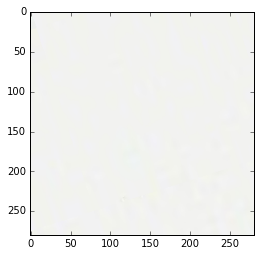

In [26]:
plt.imshow(im_he_tile)

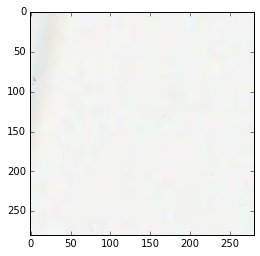

In [27]:
plt.imshow(im_stain_tile)

In [ ]:
# ii = 0
# while ii < 10000:
#     try:
#         mean = 255 
#         while mean > 200:
#             select_idx = np.random.randint(0, len(viable_centers[0]))
#             idx = (viable_centers[0][select_idx], viable_centers[1][select_idx])

#             y_center = idx[0]
#             x_center = idx[1]

#             x_coords, y_coords = np.meshgrid(np.arange(x_center - box_size[1] // 2, x_center + box_size[1] // 2),
#                                              np.arange(y_center - box_size[0] // 2, y_center + box_size[0] // 2))

#             coords = np.array(list(zip(x_coords.ravel(), y_coords.ravel(), np.ones(np.product(box_size))))).astype(int)
#             im_er_tile = im_er_orig[(coords[:, 0], coords[:, 1])].reshape(box_size + (-1, ))
#             mean = im_er_tile.mean()
        
#         aff_orig = np.copy(aff_final)
#         aff_orig[:, 2] = aff_orig[:, 2] * 10

#         trans_coords = (np.round(np.dot(aff_orig, coords.T))).T.astype(int)

#         he_trans = im_he_orig[(trans_coords[:, 0], trans_coords[:, 1])].reshape(box_size + (-1, ))
#         imsave('./he.png', he_trans)
#         b.upload_file('he.png', 'he%08d.png' % ii)
#         imsave('./er.png', im_er_tile)
#         b.upload_file('er.png', 'er%08d.png' % ii)
#         print(ii)
#         ii = ii + 1
#         boom
#     except:
#         pass